In [ ]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from datetime import datetime
import matplotlib.pyplot as plt


def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')

def load_set():
    data = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv',parse_dates =[['year','month','day','hour']],index_col = 0,date_parser=parse)
    data = data.drop(columns=['No'])
    data.columns = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
    data.index.name = 'data'
    data['pollution'].fillna(0,inplace=True)
    
    # 去掉第一天的数据
    data = data[24:]

    data.to_csv('pollution.csv')
    print(data.head())
    return data
#     data = data.dropna(axis=0)
#     data.columns = ['popul']
#     print(data.columns)

scaled = load_set()



                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
data                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [10]:

"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    
    
    le = LabelEncoder()
    print(data_set.columns)
    data_set['wnd_dir'] = LabelEncoder().fit_transform(data_set['wnd_dir'])

    data_set.values.astype('float32')
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data_set)
    print('-----------series_to_supervised-------')
    # print(scaled.shape)
    # print(scaled)
    
    train_data_set = np.array(scaled)
    

    
    reframed = series_to_supervised(train_data_set, timesteps_in, timesteps_out)
    
    reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
    
    print(reframed)
#     reframed.values[:,5] = le.fit_transform(reframed.values[:,5])
    
    n_train_hours = int(len(reframed)*0.8)
    reframed_train_data_set = np.array(reframed.values)
    # print(reframed_train_data_set[0])
#     print(reframed_train_data_set)
#     print(reframed_train_data_set.shape)
    train_x, train_y,test_x,test_y = reframed_train_data_set[:n_train_hours, :-timesteps_out], reframed_train_data_set[:n_train_hours, -timesteps_out:],reframed_train_data_set[n_train_hours:, :-timesteps_out],reframed_train_data_set[n_train_hours:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 8))
    test_x = test_x.reshape((test_x.shape[0], timesteps_in, 8))
    return train_x, train_y,test_x,test_y,reframed_train_data_set


train_x, label_y,test_x,testlablel_y,reframed_train_data_set = get_train_set(scaled, timesteps_in=timesteps_in, timesteps_out=timesteps_out)
print(train_x.shape,test_x.shape)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')
-----------series_to_supervised-------
       var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1       0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2       0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3       0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4       0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5       0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658
...          ...        ...        ...  ...        ...        ...       ...
43795   0.010060   0.264706   0.278689  ...   0.000000        0.0  0.008048
43796   0.008048   0.250000   0.278689  ...   0.000000        0.0  0.010060
43797   0.010060   0.264706   0.262295  ...   0.000000        0.0  0.010060
43798   0.010060   0.264706   0.262295  ...   0.000000        0.0  0.008048
43799   0.008

(8760, 1, 8)
Epoch 1/10
548/548 - 3s - loss: 0.0045 - val_loss: 0.0070
Epoch 2/10
548/548 - 2s - loss: 9.9875e-04 - val_loss: 0.0035
Epoch 3/10
548/548 - 2s - loss: 8.1871e-04 - val_loss: 0.0018
Epoch 4/10
548/548 - 2s - loss: 7.9608e-04 - val_loss: 0.0015
Epoch 5/10
548/548 - 2s - loss: 7.9563e-04 - val_loss: 0.0014
Epoch 6/10
548/548 - 2s - loss: 7.9709e-04 - val_loss: 0.0013
Epoch 7/10
548/548 - 2s - loss: 7.9857e-04 - val_loss: 0.0012
Epoch 8/10
548/548 - 2s - loss: 7.9959e-04 - val_loss: 0.0011
Epoch 9/10
548/548 - 2s - loss: 7.9984e-04 - val_loss: 0.0011
Epoch 10/10
548/548 - 2s - loss: 7.9960e-04 - val_loss: 0.0011


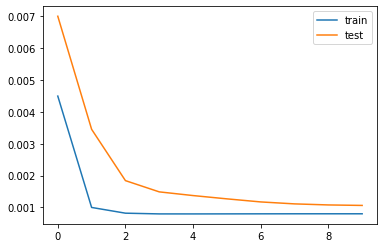

[[0.13376582]
 [0.15164033]
 [0.16433786]
 ...
 [0.0243575 ]
 [0.02867524]
 [0.02623271]]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


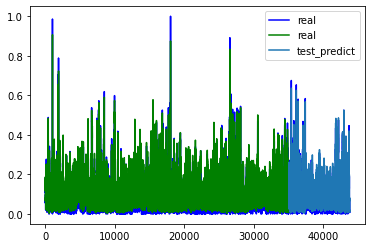

In [11]:


# 使用LSTM进行预测
def lstm_model(source_data_set, train_x, label_y, test_x,test_y,input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    # 第一层, 隐藏层神经元节点个数为128, 返回整个序列
    model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
    # 第三层 因为是回归问题所以使用linear
    model.add(Dense(timesteps_out))
    model.compile(loss='mse', optimizer='adam')
    print(test_x.shape)
    # LSTM训练 input_epochs次数
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False,validation_data=(test_x,test_y))

    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))


    test_predict = model.predict(test_x)

    plt.plot(res.history['loss'], label='train')
    plt.plot(res.history['val_loss'],label='test')
    plt.legend(loc='best')
    plt.show()
    print(train_predict)
    print(model.summary())
    plot_img(source_data_set, train_predict,test_predict)

# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict,test_predict):
    # 原始数据
    plt.plot(source_data_set[:,-1],label='real',c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict],label='real' ,c='g')

    # 预测结果
    plt.plot([None for _  in train_predict] + [x for x in test_predict ],label='test_predict')
    plt.legend(loc = 'best')
    plt.show()
    
# print(scaled.head())
timesteps_in = 1
timesteps_out = 1
epochs = 10
batch_size =64


# print(reframed.head())



lstm_model(reframed_train_data_set, train_x, label_y,test_x,testlablel_y, epochs, batch_size, timesteps_out=timesteps_out)